In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd 
import os

In [47]:
# Pandas
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical


# Audio
import librosa
import librosa.display

# Plot
import matplotlib.pyplot as plt

# Utility
import glob
import numpy as np
from tqdm import tqdm
import IPython.display as ipd
from timeit import default_timer as timer

In [3]:
ls

AnnotatedAudioFiles/
AnnotatedAudioFiles_tmp/
CNN_all/
CNN_all_classification_model.ipynb
CNN_all_preprocessing.ipynb
CNN_event_classification_model.ipynb
CNN_event_preprocessing.ipynb
CNN_model.h5
CNN_predict.ipynb
CNN_predict_data/
CNN_situation_classification_model.ipynb
CNN_situation_preprocessing.ipynb
KNN_binary.ipynb
KNN_event_classification.ipynb
KNN_predict.ipynb
KNN_situation_classification.ipynb
Untitled-Copy1.ipynb
Untitled.ipynb
Untitled1.ipynb
Untitled2.ipynb
Untitled3.ipynb
binary_classification.ipynb
convert_mp3_to_wav.ipynb
convert_wav/
convert_wav.ipynb
convert_wav_final.ipynb
crop_event.ipynb
crop_wav.ipynb
cut_file.wav
data/
data_preprocessing.ipynb
dataframe_add_file_name.ipynb
event_data_preprocesssing.csv
event_data_preprocesssing_final.csv
event_data_preprocesssing_jjin_real_final.csv
event_data_preprocesssing_real_final.csv
ffmpeg-4.4.1-amd64-static/
knn_binary_model.pkl
knn_model.pkl
knn_situation_model.pkl
model_classification2.ipynb
raw_data.ipynb
same_crop_

In [4]:
# upload the data
df = pd.read_csv('event_data_preprocesssing_real_final.csv')
df

,Unnamed: 0,waveFile,code,situation,no,event,eventCount,from,to,file_name
0,0,code0_dating-violence_01.TextGrid,code0,dating-violence,1.0,footstep,1.0,5.79780,9.44507,code0_dating-violence_01.wav
1,1,code0_dating-violence_01.TextGrid,code0,dating-violence,1.0,door,1.0,9.51020,10.35688,code0_dating-violence_01.wav
2,2,code0_dating-violence_01.TextGrid,code0,dating-violence,1.0,slang,1.0,17.71654,25.92289,code0_dating-violence_01.wav
3,3,code0_dating-violence_01.TextGrid,code0,dating-violence,2.0,groan,1.0,26.37880,34.97592,code0_dating-violence_01.wav
4,4,code0_dating-violence_01.TextGrid,code0,dating-violence,1.0,groan,1.0,37.06007,37.19033,code0_dating-violence_01.wav
...,...,...,...,...,...,...,...,...,...,...
15853,16852,normal_2(time8100to8400).TextGrid,code5,normal,7.0,male_speech,1.0,109.47259,110.95121,code5_normal_2(time8100to8400).wav
15854,16853,normal_2(time8100to8400).TextGrid,code5,normal,8.0,footstep,1.0,111.89214,112.29540,code5_normal_2(time8100to8400).wav
15855,16854,normal_2(time8100to8400).TextGrid,code5,normal,3.0,footstep,1.0,113.33131,118.34427,code5_normal_2(time8100to8400).wav
15856,16855,normal_2(time8100to8400).TextGrid,code5,normal,4.0,footstep,1.0,119.01636,123.04894,code5_normal_2(time8100to8400).wav


In [5]:
df['situation'].value_counts()

candid cam          2872
robber              1948
crying-man          1769
candid-cam          1716
crying-woman        1173
normal              1070
inebriate-woman      815
violence             786
flasher              610
inebriated woman     454
dating-violence      444
disorder             390
disorder-woman       281
disorder-man         255
injury               241
drunken man          230
inebriate-man        220
drunken woman        156
invasion             139
inebriated man       112
office-violence       73
inebriated            60
sponsor               44
Name: situation, dtype: int64

In [17]:
# class_id = [i for i in range(0,23)]
# class_name = list(df['situation'].unique())
# class_code = {v:k for k,v in zip(class_id, class_name)}
# print(class_code)

{'dating-violence': 0, 'injury': 1, 'office-violence': 2, 'robber': 3, 'sponsor': 4, 'violence': 5, 'candid cam': 6, 'candid-cam': 7, 'disorder-man': 8, 'disorder-woman': 9, 'disorder': 10, 'drunken man': 11, 'drunken woman': 12, 'flasher': 13, 'inebriate-man': 14, 'inebriate-woman': 15, 'inebriated man': 16, 'inebriated woman': 17, 'inebriated': 18, 'invasion': 19, 'crying-man': 20, 'crying-woman': 21, 'normal': 22}


In [65]:
class_code = {'dating-violence': 0, 'injury': 1, 'office-violence': 2, 'rape':3, 'robber': 4, 'sponsor': 5, 'violence': 6, 
              'candid-cam': 7, 'disorder': 8, 'drunken': 9, 'flasher': 10, 'inebriate': 11, 'invasion': 12, 'crying': 13, 'normal': 14}

In [132]:
# Building our dataset
dataset = list()
for folder in glob.glob('CNN_all/cut_from5_to35/'):
    list_sounds_path = glob.glob(folder+"//**")
    for elm in list_sounds_path:
        elm1 = elm.split("/")[2]
        idx = elm1.find('_')
        label = elm1[idx+1:].replace(".wav","").split("_")[0]
        if label == "candid cam":
            label = "candid-cam"
        if label == "inebriated man" or label == "inebriated" or label == "inebriate-man" or label == "inebriated woman" or label == "inebriate-woman":
            label = "inebriate"
        if label == "crying-man" or label == "crying-woman":
            label = "crying"
        if label == "drunken man" or label == "drunken woman":
            label = "drunken"
        if label == "disorder-man" or label == "disorder-woman":
            label = "disorder"
        dataset.append({"file_name" : elm,
                       "label" : class_code[label]})
        pass
    pass
pass
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state = 42)

In [133]:
dataset.head(10)

,file_name,label
438,CNN_all/cut_from5_to35/code3_crying-man_36.wav,13
570,CNN_all/cut_from5_to35/code5_normal_2(time9300...,14
567,CNN_all/cut_from5_to35/code3_crying-man_B09.wav,13
534,CNN_all/cut_from5_to35/code5_normal_3(time1500...,14
1617,CNN_all/cut_from5_to35/code1_candid-cam_D70.wav,7
135,CNN_all/cut_from5_to35/code1_candid-cam_C02.wav,7
1302,CNN_all/cut_from5_to35/code0_injury_B21.wav,1
70,CNN_all/cut_from5_to35/code3_crying-man_A36.wav,13
342,CNN_all/cut_from5_to35/code0_robber_B_26.wav,4
289,CNN_all/cut_from5_to35/code0_dating-violence_2...,0


In [131]:
dataset['label'].value_counts()

candid-cam         357
crying             272
robber             207
normal             183
inebriate          164
disorder           136
dating-violence     90
flasher             74
violence            37
drunken             34
rape                31
office-violence     25
invasion            24
injury              23
sponsor             15
Name: label, dtype: int64

In [86]:
train, test = train_test_split(dataset, test_size = 0.2, random_state = 42)

In [87]:
print(train.shape)
print(test.shape)

(1337, 2)
(335, 2)


In [88]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    return mfccs

In [89]:
x_train = list()
y_train = list()
for i in tqdm(range(len(train))):
    x_train.append(extract_feature(train.file_name.iloc[i]))
    y_train.append(train.label.iloc[i])
    pass
pass

100%|██████████| 1337/1337 [25:39<00:00,  1.15s/it]


In [90]:
y_train

[7,
 13,
 11,
 4,
 10,
 13,
 7,
 4,
 10,
 7,
 5,
 7,
 0,
 9,
 14,
 14,
 7,
 0,
 10,
 14,
 0,
 12,
 0,
 7,
 4,
 13,
 13,
 7,
 12,
 11,
 10,
 11,
 4,
 7,
 10,
 4,
 11,
 8,
 11,
 8,
 11,
 0,
 8,
 7,
 7,
 13,
 14,
 4,
 14,
 13,
 13,
 13,
 11,
 11,
 14,
 4,
 7,
 3,
 7,
 11,
 6,
 7,
 7,
 14,
 4,
 11,
 8,
 11,
 10,
 7,
 6,
 11,
 10,
 14,
 11,
 4,
 13,
 7,
 0,
 7,
 7,
 7,
 13,
 3,
 4,
 7,
 13,
 13,
 7,
 4,
 13,
 4,
 3,
 14,
 13,
 7,
 7,
 0,
 13,
 13,
 13,
 9,
 13,
 11,
 4,
 11,
 0,
 14,
 13,
 13,
 11,
 13,
 8,
 10,
 11,
 6,
 13,
 0,
 11,
 13,
 4,
 7,
 7,
 14,
 7,
 7,
 7,
 11,
 4,
 13,
 14,
 10,
 14,
 10,
 14,
 7,
 7,
 4,
 8,
 4,
 11,
 4,
 13,
 13,
 4,
 7,
 11,
 14,
 13,
 11,
 7,
 12,
 8,
 7,
 10,
 6,
 14,
 13,
 14,
 9,
 2,
 14,
 14,
 8,
 0,
 13,
 4,
 8,
 13,
 4,
 11,
 7,
 4,
 8,
 8,
 4,
 4,
 7,
 6,
 4,
 10,
 13,
 9,
 13,
 9,
 8,
 0,
 14,
 11,
 8,
 8,
 9,
 7,
 14,
 4,
 8,
 13,
 4,
 7,
 7,
 11,
 7,
 11,
 8,
 8,
 4,
 7,
 13,
 6,
 8,
 13,
 13,
 10,
 2,
 0,
 4,
 13,
 0,
 11,
 12,
 8,
 14,
 11,
 7,


In [91]:
x_test = list()
y_test = list()
for i in tqdm(range(len(test))):
    x_test.append(extract_feature(test.file_name.iloc[i]))
    y_test.append(test.label.iloc[i])
    pass
pass

100%|██████████| 335/335 [06:21<00:00,  1.14s/it]


In [92]:
train_y

[]

In [93]:
print("x_train",len(x_train),"y_train", len(y_train))

x_train 1337 y_train 1337


In [94]:
X_train, Y_train = list(), list()
train_x = list()
train_y = list()
for x,y in zip(x_train,y_train):
    train_x.append(x.shape)
    train_y.append(y.shape)
    X_train.append(x)
    Y_train.append(y)

In [95]:
X_test, Y_test = list(), list()
test_x = list()
test_y = list()
for x,y in zip(x_test,y_test):
    test_x.append(x.shape)
    test_y.append(y.shape)
    X_test.append(x)
    Y_test.append(y)

In [96]:
print("x_train",len(x_train),"y_train", len(y_train))

x_train 1337 y_train 1337


In [97]:
print("x_test",len(x_test),"y_test", len(y_test))

x_test 335 y_test 335


In [98]:
# 오디오 재생시간이 다르기 때문에 프레임 수가 각각 다름
print(test_x.sort(reverse=True))
test_x

None


[(40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),
 (40, 1292),

In [99]:
# Q. 주요 특성이 (40,1292)인가?? 
X_train, Y_train = list(), list()
for x,y in zip(x_train,y_train):
    if x.shape == (40, 1292):
        X_train.append(x)
        Y_train.append(y)
        pass
    pass
pass

In [100]:
X_test, Y_test = list(), list()
for x,y in zip(x_test,y_test):
    if x.shape == (40, 1292):
        X_test.append(x)
        Y_test.append(y)
        pass
    pass
pass

In [101]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [102]:
Y_train

array([13, 11,  4, ..., 14, 14, 14])

In [103]:
print(X_train.shape)
print(X_test.shape)

(1088, 40, 1292)
(269, 40, 1292)


In [104]:
# time : 전체 쉘에 대한 Wall time
# LabelEncoder() : 문자를 숫자(수치화), 숫자를 문자로 매핑
%%time
encoder = LabelEncoder()
encoder.fit(Y_train)

Y_train = encoder.transform(Y_train)
Y_test = encoder.transform(Y_test)

UsageError: Line magic function `%%time` not found.


In [105]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
Y_train1 = to_categorical(Y_train)
Y_test1 = to_categorical(Y_test)

In [106]:
Y_train1

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [107]:
X_test.shape

(269, 40, 1292, 1)

In [108]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(40, 1292, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(15, activation='softmax'))

In [109]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [110]:
history = model.fit(X_train, Y_train1,
              batch_size=128,
              epochs=300,
              validation_data=(X_test, Y_test1),
              shuffle=True)

Epoch 1/300
9/9 [==============================] - 9s 943ms/step - loss: 10.7328 - accuracy: 0.1599 - val_loss: 3.5154 - val_accuracy: 0.0335
Epoch 2/300
9/9 [==============================] - 8s 912ms/step - loss: 3.2255 - accuracy: 0.2390 - val_loss: 2.1087 - val_accuracy: 0.1822
Epoch 3/300
9/9 [==============================] - 8s 913ms/step - loss: 2.2343 - accuracy: 0.3382 - val_loss: 1.9934 - val_accuracy: 0.4387
Epoch 4/300
9/9 [==============================] - 8s 900ms/step - loss: 1.8646 - accuracy: 0.3971 - val_loss: 1.9836 - val_accuracy: 0.4981
Epoch 5/300
9/9 [==============================] - 8s 905ms/step - loss: 1.7067 - accuracy: 0.4531 - val_loss: 1.9751 - val_accuracy: 0.4015
Epoch 6/300
9/9 [==============================] - 8s 900ms/step - loss: 1.6452 - accuracy: 0.4779 - val_loss: 1.8625 - val_accuracy: 0.5353
Epoch 7/300
9/9 [==============================] - 8s 909ms/step - loss: 1.5485 - accuracy: 0.5312 - val_loss: 1.8203 - val_accuracy: 0.5651
Epoch 8/300


Text(0.5, 1.0, 'Accuracy Curves')

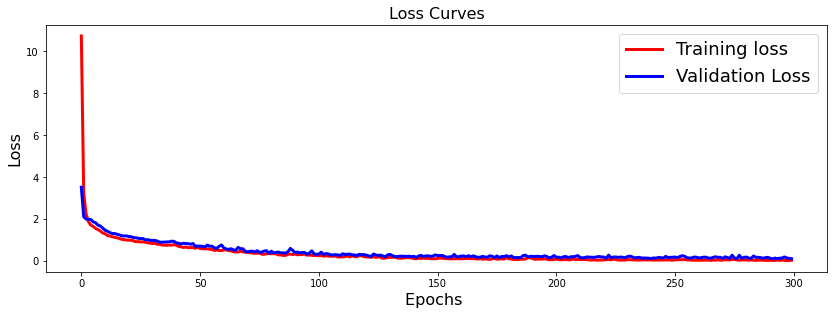

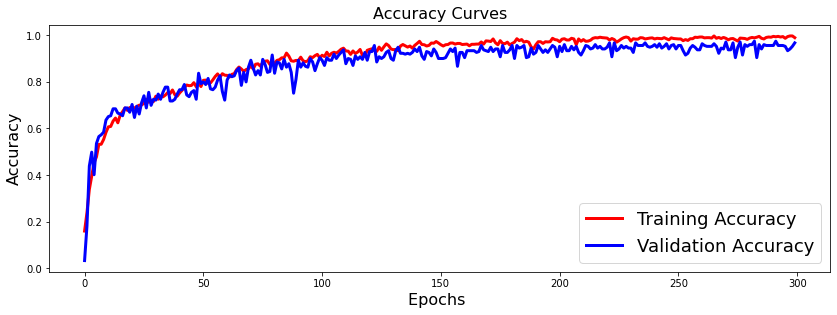

In [111]:
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [112]:
model.save("CNN_all_model_final.h5")